In [39]:
import ase
from ase import Atoms
import numpy as np
import json
from icet.tools import ConvexHull

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["mathtext.fontset"] ='custom'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica'
plt.rcParams["font.size"] = '6'
plt.rcParams['axes.linewidth'] = 0.75
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4

In [40]:
structures = []
energies = []
Mn_compositions = []

def get_json(filename):

    with open(f'../Data/Data_thermodynamics/{filename}.json') as data:
            cluster_data = json.load(data)
    for n, calculation in enumerate(cluster_data['calculation_results']):
        atoms = ase.Atoms(numbers=calculation['structure']['numbers'],
                          positions=calculation['structure']['positions'],
                          pbc=calculation['structure']['pbc'],
                          cell=calculation['structure']['cell'])
        numbers = atoms.numbers
        epfu = float(calculation['energy']) / ( np.count_nonzero(numbers == 8) )
        x_Mn = ( np.count_nonzero(numbers == 25) / np.count_nonzero(numbers == 8) ) 
        energies.append(epfu)
        Mn_compositions.append(x_Mn)
        structures.append(atoms)

In [41]:
get_json('LLMO_HSE_full_structure_set')
get_json('LLMO_HSE_MnO_endmember')
get_json('LLMO_HSE_confined_O2_endmember')
get_json('LLMO_HSE_gas_O2_endmember')

In [42]:
# The final structure is the isolated O2 molecule in a box. 
# To approximate the free energy of O2 gas, we add the rotational and translational 
# enthalpy and experimentally measured entropy of O2 at 1 atm and 298 K
print('isolated O2 in a box has an energy of:',f'{energies[-1]:.3f}','eV atom^{–1}')
print(structures[-1])

# rotational and translational enthalpy and experimentally measured entropy of O2 at 
# 1 atm and 298 K
entropy_298K = 0.00212468/2
rotational_enthalpy = 0.000257/2
translational_enthalpy = 0.000384/2

energy_correction = entropy_298K + rotational_enthalpy + translational_enthalpy
print('correction per atom is:',f'{energy_correction:.3f}','eV')
energies[-1] = energies[-1] + energy_correction
print('free energy of O2 gas is:',f'{energies[-1]:.3f}','eV atom^{–1}')


isolated O2 in a box has an energy of: -510.927 eV atom^{–1}
Atoms(symbols='O2', pbc=False, cell=[1.0, 1.0, 1.0])
correction per atom is: 0.001 eV
free energy of O2 gas is: -510.925 eV atom^{–1}


In [43]:
# Define the specific endmembers with which we want to calculate our convexhull.
# Note that the convex hull is calculated relative to bulk O2

MnO_struc_e = (energies[-3])
O2_bulk_e = (energies[-2])

In [44]:
formation_energies = []
for e, x in zip(energies, Mn_compositions):
    form_e = (e - ((x)*MnO_struc_e) - ( (1-(x)) *O2_bulk_e))
    formation_energies.append(form_e)
print(len(formation_energies))

775


In [45]:
# use icet convex hull tool to compute the convex hulls for the system including gas O2
conv_hull_O2_gas = ConvexHull(Mn_compositions,formation_energies)

# now, we remove the O2 gas value from the dataset, and compute a hull for bulk confined O2
Mn_compositions.pop(-1)
formation_energies.pop(-1)

conv_hull_O2_bulk = ConvexHull(Mn_compositions,formation_energies)


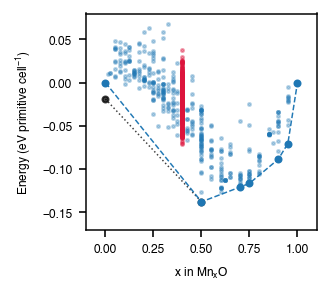

In [46]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(1.6, 1.5))
a = axes

a.plot(conv_hull_O2_gas.concentrations[:2],conv_hull_O2_gas.energies[:2],'o:', 
       color = 'black', alpha = 0.75, markersize = 3)

for x, e in zip(Mn_compositions,formation_energies):
    if x == 0.4:
        a.plot(x,e,'o', color = 'crimson', alpha = 0.4, markersize = 1.5)
    else:
        a.plot(x,e,'o', color = 'tab:blue', alpha = 0.3, markersize = 1.5)
a.plot(conv_hull_O2_bulk.concentrations,conv_hull_O2_bulk.energies,'o--', 
       color = 'tab:blue', alpha = 0.99, markersize = 3)

a.set_ylim(-0.17, 0.08)
a.set_xlim(-0.1, 1.1)
a.set_ylabel('Energy (eV primitive cell$^{-1}$)')
a.set_xlabel('x in Mn$_{x}O$')
fig.subplots_adjust(bottom=0.0, top=1.0, left=0.0, right=1,
                    wspace=0.00, hspace=0.05)

#plt.savefig('Fig_3a_conv_hull.svg', dpi=300, bbox_inches='tight', format='svg')